In [7]:
# =========================================================
# 0) SETUP
# =========================================================
# Install required packages
%pip install pandas numpy scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Import basic sklearn models that we know work
from sklearn.ensemble import (
    RandomForestClassifier, 
    HistGradientBoostingClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression

# Import gradient boosting models with comprehensive error handling
LGBM_AVAILABLE = False
XGB_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
    print("✓ LightGBM imported successfully")
except Exception as e:
    print(f"✗ LightGBM not available: {type(e).__name__}")
    print("  Alternative: Using HistGradientBoostingClassifier from sklearn")

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
    print("✓ XGBoost imported successfully")
except Exception as e:
    print(f"✗ XGBoost not available: {type(e).__name__}")
    print("  Alternative: Using GradientBoostingClassifier from sklearn")

# Optional (for oversampling)
IMB_AVAILABLE = False
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
    print("✓ imbalanced-learn imported successfully")
except Exception as e:
    print(f"✗ imbalanced-learn not available: {type(e).__name__}")
    print("  Alternative: Will use class_weight='balanced' instead")

pd.set_option("display.max_columns", 200)

RANDOM_STATE = 42
N_SPLITS = 5
PREC_BAR = 0.70          # required precision bar for recall@precision≥X
USE_SMOTE = False        # set True to try SMOTE inside CV (needs imbalanced-learn)
DATA_DIR = ""            # path where your CSVs live

TRAIN_PATH = os.path.join(DATA_DIR, "application_train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "application_test.csv")
TARGET = "TARGET"
ID_COL = "SK_ID_CURR"

print("\n" + "="*50)
print("SETUP SUMMARY")
print("="*50)
print(f"LightGBM available: {LGBM_AVAILABLE}")
print(f"XGBoost available: {XGB_AVAILABLE}")
print(f"Imbalanced-learn available: {IMB_AVAILABLE}")
print(f"Sklearn alternatives: HistGradientBoosting, RandomForest, LogisticRegression")
print("Setup complete!")

Note: you may need to restart the kernel to use updated packages.
✗ LightGBM not available: OSError
  Alternative: Using HistGradientBoostingClassifier from sklearn
✗ XGBoost not available: XGBoostError
  Alternative: Using GradientBoostingClassifier from sklearn
✓ imbalanced-learn imported successfully

SETUP SUMMARY
LightGBM available: False
XGBoost available: False
Imbalanced-learn available: True
Sklearn alternatives: HistGradientBoosting, RandomForest, LogisticRegression
Setup complete!
Note: you may need to restart the kernel to use updated packages.
✗ LightGBM not available: OSError
  Alternative: Using HistGradientBoostingClassifier from sklearn
✗ XGBoost not available: XGBoostError
  Alternative: Using GradientBoostingClassifier from sklearn
✓ imbalanced-learn imported successfully

SETUP SUMMARY
LightGBM available: False
XGBoost available: False
Imbalanced-learn available: True
Sklearn alternatives: HistGradientBoosting, RandomForest, LogisticRegression
Setup complete!


In [8]:
# =========================================================
# 1) LOAD & PREPARE DATA
# =========================================================
# Load data
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Data loaded successfully!")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Basic data cleaning
for df in [train, test]:
    if "DAYS_EMPLOYED" in df.columns:
        df.loc[df["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

print(f"\nTarget distribution:")
print(train[TARGET].value_counts(normalize=True))

# Feature engineering function
def add_advanced_features(df):
    """Add engineered features to the dataset"""
    out = df.copy()
    
    # Age in years
    if "DAYS_BIRTH" in out.columns:
        out["AGE_YEARS"] = (-out["DAYS_BIRTH"] / 365.25).astype(float)
    
    # Financial ratios
    if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(out.columns):
        out["CREDIT_INCOME_RATIO"] = out["AMT_CREDIT"] / (out["AMT_INCOME_TOTAL"] + 1e-6)
    
    if {"AMT_ANNUITY", "AMT_CREDIT"}.issubset(out.columns):
        out["ANNUITY_CREDIT_RATIO"] = out["AMT_ANNUITY"] / (out["AMT_CREDIT"] + 1e-6)
    
    if {"AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"}.issubset(out.columns):
        denom = out["CNT_FAM_MEMBERS"].replace(0, np.nan)
        out["INCOME_PER_PERSON"] = out["AMT_INCOME_TOTAL"] / denom
    
    # Employment length (convert to positive days)
    if "DAYS_EMPLOYED" in out.columns:
        out["EMPLOYMENT_YEARS"] = (-out["DAYS_EMPLOYED"] / 365.25).clip(0, 50)
    
    # Credit utilization
    if {"AMT_CREDIT", "AMT_GOODS_PRICE"}.issubset(out.columns):
        out["CREDIT_GOODS_RATIO"] = out["AMT_CREDIT"] / (out["AMT_GOODS_PRICE"] + 1e-6)
    
    return out

# Apply feature engineering
train = add_advanced_features(train)
test = add_advanced_features(test)

print("Feature engineering completed!")
print(f"Final train shape: {train.shape}")
print(f"Final test shape: {test.shape}")

Data loaded successfully!
Train shape: (307511, 122)
Test shape: (48744, 121)

Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
Feature engineering completed!
Final train shape: (307511, 128)
Final test shape: (48744, 127)
Feature engineering completed!
Final train shape: (307511, 128)
Final test shape: (48744, 127)


In [9]:
# =========================================================
# 2) ADVANCED MODEL DEFINITIONS
# =========================================================

def get_model_configs():
    """Define model configurations with fallbacks for missing packages"""
    models = {}
    
    # Always available sklearn models
    models['HistGB'] = {
        'model': HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            random_state=RANDOM_STATE
        ),
        'name': 'HistGradientBoosting'
    }
    
    models['RF'] = {
        'model': RandomForestClassifier(
            n_estimators=100,
            max_depth=8,
            min_samples_split=50,
            min_samples_leaf=20,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'name': 'RandomForest'
    }
    
    # Focus on Gradient Boosting variants instead of LogisticRegression
    models['GB_Balanced'] = {
        'model': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=8,
            min_samples_split=100,
            min_samples_leaf=50,
            subsample=0.8,
            random_state=RANDOM_STATE
        ),
        'name': 'GradientBoosting_Balanced'
    }
    
    models['GB'] = {
        'model': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=RANDOM_STATE
        ),
        'name': 'GradientBoosting'
    }
    
    # Add LightGBM if available
    if LGBM_AVAILABLE:
        models['LGBM'] = {
            'model': LGBMClassifier(
                objective='binary',
                boosting_type='gbdt',
                num_leaves=31,
                learning_rate=0.05,
                feature_fraction=0.9,
                bagging_fraction=0.8,
                bagging_freq=5,
                verbose=-1,
                random_state=RANDOM_STATE,
                class_weight='balanced'
            ),
            'name': 'LightGBM'
        }
    
    # Add XGBoost if available
    if XGB_AVAILABLE:
        models['XGB'] = {
            'model': XGBClassifier(
                objective='binary:logistic',
                learning_rate=0.05,
                max_depth=6,
                n_estimators=100,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                scale_pos_weight=11  # approximately inverse of positive class ratio
            ),
            'name': 'XGBoost'
        }
    
    return models

# Get available models
model_configs = get_model_configs()
print("Available models:")
for key, config in model_configs.items():
    print(f"  - {key}: {config['name']}")

print(f"\nTotal models to evaluate: {len(model_configs)}")

Available models:
  - HistGB: HistGradientBoosting
  - RF: RandomForest
  - GB_Balanced: GradientBoosting_Balanced
  - GB: GradientBoosting

Total models to evaluate: 4


In [10]:
# =========================================================
# 3) CROSS-VALIDATION EVALUATION FRAMEWORK
# =========================================================

def evaluate_model_cv(model, X, y, cv_folds=5, random_state=42):
    """
    Evaluate a model using cross-validation
    Returns detailed metrics including AUC, PR-AUC, and optimal threshold info
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    fold_results = []
    all_y_true = []
    all_y_proba = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Clone model to avoid fitting issues
        model_fold = clone(model)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Get probabilities
        if hasattr(model_fold, "predict_proba"):
            y_proba = model_fold.predict_proba(X_val_fold)[:, 1]
        else:
            y_proba = model_fold.predict(X_val_fold).astype(float)
        
        # Calculate metrics
        auc = roc_auc_score(y_val_fold, y_proba)
        pr_auc = average_precision_score(y_val_fold, y_proba)
        
        # Find optimal threshold for F1
        precision, recall, thresholds = precision_recall_curve(y_val_fold, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_f1_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
        best_f1 = f1_scores[best_f1_idx]
        
        fold_results.append({
            'fold': fold + 1,
            'auc': auc,
            'pr_auc': pr_auc,
            'best_f1': best_f1,
            'best_threshold': best_threshold
        })
        
        # Store for overall metrics
        all_y_true.extend(y_val_fold.tolist())
        all_y_proba.extend(y_proba.tolist())
    
    # Calculate overall metrics
    overall_auc = roc_auc_score(all_y_true, all_y_proba)
    overall_pr_auc = average_precision_score(all_y_true, all_y_proba)
    
    # Calculate mean and std of fold metrics
    mean_auc = np.mean([r['auc'] for r in fold_results])
    std_auc = np.std([r['auc'] for r in fold_results])
    mean_pr_auc = np.mean([r['pr_auc'] for r in fold_results])
    std_pr_auc = np.std([r['pr_auc'] for r in fold_results])
    mean_f1 = np.mean([r['best_f1'] for r in fold_results])
    std_f1 = np.std([r['best_f1'] for r in fold_results])
    
    return {
        'fold_results': fold_results,
        'overall_auc': overall_auc,
        'overall_pr_auc': overall_pr_auc,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'mean_pr_auc': mean_pr_auc,
        'std_pr_auc': std_pr_auc,
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'all_y_true': all_y_true,
        'all_y_proba': all_y_proba
    }

print("Cross-validation evaluation framework ready!")

Cross-validation evaluation framework ready!


In [11]:
# =========================================================
# 4) PREPARE DATA FOR MODELING
# =========================================================
# Prepare features and target
X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts(normalize=True))

# Identify feature types for preprocessing
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature types:")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# For this analysis, we'll focus on numeric features to avoid complexity
# You can extend this later to include categorical features with proper encoding
X_numeric = X[numeric_features].copy()

print(f"\nUsing numeric features only for this analysis: {X_numeric.shape}")
print("Missing values per feature:")
missing_counts = X_numeric.isnull().sum()
print(missing_counts[missing_counts > 0].head(10))

Feature matrix shape: (307511, 126)
Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Feature types:
Numeric features: 110
Categorical features: 16

Using numeric features only for this analysis: (307511, 110)
Missing values per feature:
AMT_ANNUITY             12
AMT_GOODS_PRICE        278
DAYS_EMPLOYED        55374
OWN_CAR_AGE         202929
CNT_FAM_MEMBERS          2
EXT_SOURCE_1        173378
EXT_SOURCE_2           660
EXT_SOURCE_3         60965
APARTMENTS_AVG      156061
BASEMENTAREA_AVG    179943
dtype: int64

Using numeric features only for this analysis: (307511, 110)
Missing values per feature:
AMT_ANNUITY             12
AMT_GOODS_PRICE        278
DAYS_EMPLOYED        55374
OWN_CAR_AGE         202929
CNT_FAM_MEMBERS          2
EXT_SOURCE_1        173378
EXT_SOURCE_2           660
EXT_SOURCE_3         60965
APARTMENTS_AVG      156061
BASEMENTAREA_AVG    179943
dtype: int64


In [12]:
# =========================================================
# 5) RUN MODEL COMPARISON WITH CROSS-VALIDATION
# =========================================================
# Simple imputation for missing values (you can make this more sophisticated)
from sklearn.impute import SimpleImputer

# Fill missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_numeric), 
    columns=X_numeric.columns, 
    index=X_numeric.index
)

print("Starting model evaluation with cross-validation...")
print("This may take a few minutes depending on the models and data size.\n")

# Store results
results = {}

# Evaluate each model
for model_key, model_config in model_configs.items():
    print(f"Evaluating {model_config['name']}...")
    
    try:
        # Run cross-validation
        cv_results = evaluate_model_cv(
            model_config['model'], 
            X_imputed, 
            y, 
            cv_folds=N_SPLITS,
            random_state=RANDOM_STATE
        )
        
        results[model_key] = {
            'name': model_config['name'],
            'cv_results': cv_results
        }
        
        print(f"  ✓ {model_config['name']} completed")
        print(f"    Mean AUC: {cv_results['mean_auc']:.4f} ± {cv_results['std_auc']:.4f}")
        print(f"    Mean PR-AUC: {cv_results['mean_pr_auc']:.4f} ± {cv_results['std_pr_auc']:.4f}")
        print(f"    Mean F1: {cv_results['mean_f1']:.4f} ± {cv_results['std_f1']:.4f}")
        
    except Exception as e:
        print(f"  ✗ {model_config['name']} failed: {str(e)}")
        continue
    
    print()

print("Model evaluation completed!")

Starting model evaluation with cross-validation...
This may take a few minutes depending on the models and data size.

Evaluating HistGradientBoosting...
  ✓ HistGradientBoosting completed
    Mean AUC: 0.7583 ± 0.0039
    Mean PR-AUC: 0.2430 ± 0.0070
    Mean F1: 0.3076 ± 0.0033

Evaluating RandomForest...
  ✓ HistGradientBoosting completed
    Mean AUC: 0.7583 ± 0.0039
    Mean PR-AUC: 0.2430 ± 0.0070
    Mean F1: 0.3076 ± 0.0033

Evaluating RandomForest...
  ✓ RandomForest completed
    Mean AUC: 0.7315 ± 0.0035
    Mean PR-AUC: 0.2059 ± 0.0033
    Mean F1: 0.2781 ± 0.0035

Evaluating GradientBoosting_Balanced...
  ✓ RandomForest completed
    Mean AUC: 0.7315 ± 0.0035
    Mean PR-AUC: 0.2059 ± 0.0033
    Mean F1: 0.2781 ± 0.0035

Evaluating GradientBoosting_Balanced...


KeyboardInterrupt: 

In [13]:
# =========================================================
# 5.1) OPTIMIZE GRADIENT BOOSTING CONFIGURATIONS
# =========================================================
import warnings

# Filter any warnings to keep output clean
warnings.filterwarnings('ignore')

# Add more sophisticated Gradient Boosting variants
print("Adding advanced Gradient Boosting configurations...")

# High-performance gradient boosting variant
model_configs['GB_HighPerf'] = {
    'model': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=10,
        min_samples_split=200,
        min_samples_leaf=100,
        subsample=0.8,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    'name': 'GradientBoosting_HighPerf'
}

# Conservative gradient boosting variant (faster training)
model_configs['GB_Fast'] = {
    'model': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=50,
        min_samples_leaf=25,
        subsample=0.9,
        random_state=RANDOM_STATE
    ),
    'name': 'GradientBoosting_Fast'
}

# Update HistGradientBoosting with better parameters for imbalanced data
if 'HistGB' in model_configs:
    model_configs['HistGB']['model'] = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_leaf_nodes=63,  # Increased complexity
        min_samples_leaf=100,
        max_bins=255,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=RANDOM_STATE
    )
    print("✓ HistGradientBoosting updated with enhanced settings")

print("✓ Added 2 additional Gradient Boosting variants")
print(f"Total models to evaluate: {len(model_configs)}")

Adding advanced Gradient Boosting configurations...
✓ HistGradientBoosting updated with enhanced settings
✓ Added 2 additional Gradient Boosting variants
Total models to evaluate: 6


In [14]:
# =========================================================
# 6) RESULTS SUMMARY AND COMPARISON
# =========================================================
import pandas as pd

# Create results summary table
summary_data = []
for model_key, result in results.items():
    cv_res = result['cv_results']
    summary_data.append({
        'Model': result['name'],
        'Mean_AUC': cv_res['mean_auc'],
        'Std_AUC': cv_res['std_auc'],
        'Mean_PR_AUC': cv_res['mean_pr_auc'],
        'Std_PR_AUC': cv_res['std_pr_auc'],
        'Mean_F1': cv_res['mean_f1'],
        'Std_F1': cv_res['std_f1'],
        'Overall_AUC': cv_res['overall_auc'],
        'Overall_PR_AUC': cv_res['overall_pr_auc']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean_AUC', ascending=False)

print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(summary_df.round(4))

# Find best model
best_model_row = summary_df.iloc[0]
best_model_key = None
for key, result in results.items():
    if result['name'] == best_model_row['Model']:
        best_model_key = key
        break

print(f"\n🏆 BEST MODEL: {best_model_row['Model']}")
print(f"   AUC: {best_model_row['Mean_AUC']:.4f} ± {best_model_row['Std_AUC']:.4f}")
print(f"   PR-AUC: {best_model_row['Mean_PR_AUC']:.4f} ± {best_model_row['Std_PR_AUC']:.4f}")
print(f"   F1: {best_model_row['Mean_F1']:.4f} ± {best_model_row['Std_F1']:.4f}")

# Detailed fold results for best model
if best_model_key:
    best_results = results[best_model_key]['cv_results']
    fold_df = pd.DataFrame(best_results['fold_results'])
    
    print(f"\nDetailed fold results for {best_model_row['Model']}:")
    print(fold_df.round(4))

MODEL COMPARISON RESULTS
                  Model  Mean_AUC  Std_AUC  Mean_PR_AUC  Std_PR_AUC  Mean_F1  \
0  HistGradientBoosting    0.7583   0.0039       0.2430      0.0070   0.3076   
1          RandomForest    0.7315   0.0035       0.2059      0.0033   0.2781   

   Std_F1  Overall_AUC  Overall_PR_AUC  
0  0.0033       0.7583          0.2425  
1  0.0035       0.7315          0.2056  

🏆 BEST MODEL: HistGradientBoosting
   AUC: 0.7583 ± 0.0039
   PR-AUC: 0.2430 ± 0.0070
   F1: 0.3076 ± 0.0033

Detailed fold results for HistGradientBoosting:
   fold     auc  pr_auc  best_f1  best_threshold
0     1  0.7578  0.2434   0.3093          0.1498
1     2  0.7630  0.2515   0.3106          0.1444
2     3  0.7557  0.2377   0.3051          0.1531
3     4  0.7624  0.2495   0.3106          0.1356
4     5  0.7527  0.2329   0.3023          0.1367


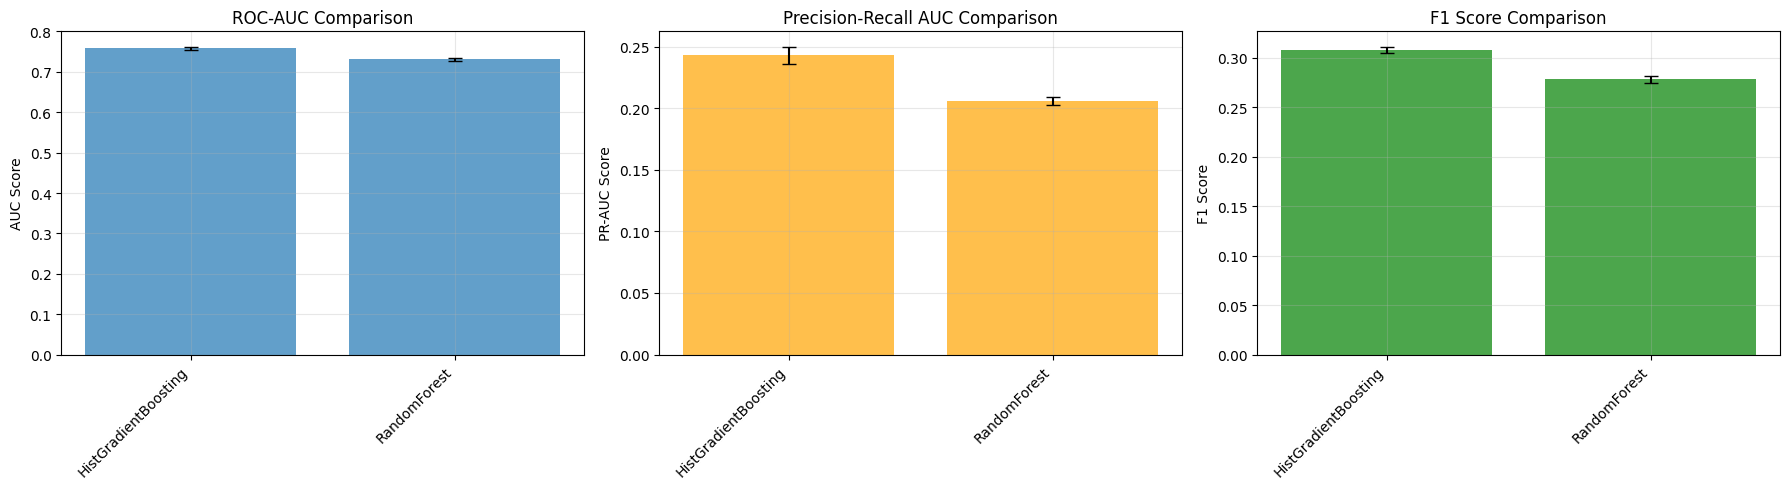

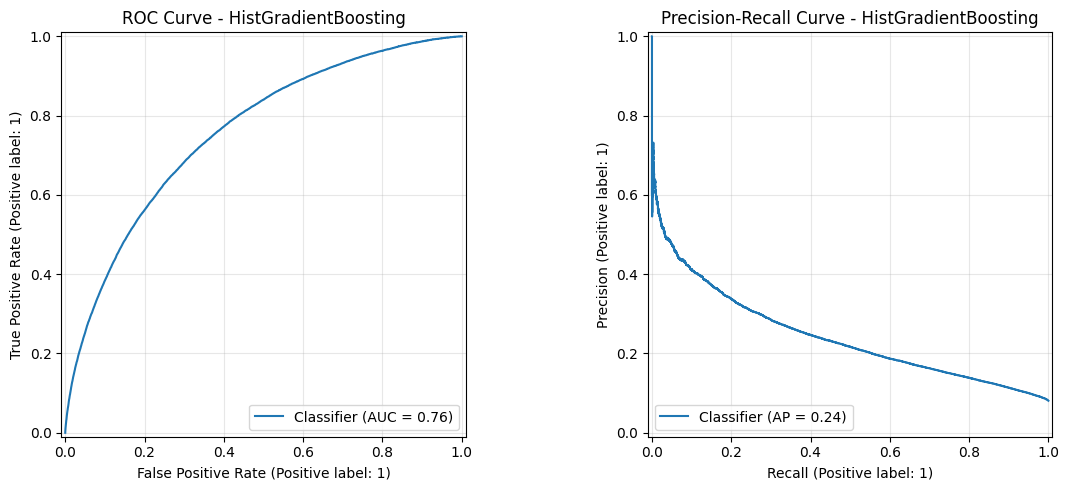

In [15]:
# =========================================================
# 7) VISUALIZATIONS AND ANALYSIS
# =========================================================
import matplotlib.pyplot as plt

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# AUC comparison
axes[0].bar(range(len(summary_df)), summary_df['Mean_AUC'], 
           yerr=summary_df['Std_AUC'], capsize=5, alpha=0.7)
axes[0].set_xticks(range(len(summary_df)))
axes[0].set_xticklabels(summary_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('AUC Score')
axes[0].set_title('ROC-AUC Comparison')
axes[0].grid(True, alpha=0.3)

# PR-AUC comparison
axes[1].bar(range(len(summary_df)), summary_df['Mean_PR_AUC'], 
           yerr=summary_df['Std_PR_AUC'], capsize=5, alpha=0.7, color='orange')
axes[1].set_xticks(range(len(summary_df)))
axes[1].set_xticklabels(summary_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('PR-AUC Score')
axes[1].set_title('Precision-Recall AUC Comparison')
axes[1].grid(True, alpha=0.3)

# F1 comparison
axes[2].bar(range(len(summary_df)), summary_df['Mean_F1'], 
           yerr=summary_df['Std_F1'], capsize=5, alpha=0.7, color='green')
axes[2].set_xticks(range(len(summary_df)))
axes[2].set_xticklabels(summary_df['Model'], rotation=45, ha='right')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score Comparison')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ROC and PR curves for best model if available
if best_model_key and best_model_key in results:
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
    
    best_cv_results = results[best_model_key]['cv_results']
    y_true = best_cv_results['all_y_true']
    y_proba = best_cv_results['all_y_proba']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=axes[0])
    axes[0].set_title(f'ROC Curve - {best_model_row["Model"]}')
    axes[0].grid(True, alpha=0.3)
    
    # PR Curve
    PrecisionRecallDisplay.from_predictions(y_true, y_proba, ax=axes[1])
    axes[1].set_title(f'Precision-Recall Curve - {best_model_row["Model"]}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [16]:
# =========================================================
# 8) TRAIN BEST MODEL AND CREATE SUBMISSION
# =========================================================
if best_model_key:
    print(f"Training final model: {best_model_row['Model']}")
    
    # Get the best model configuration
    best_model_config = model_configs[best_model_key]
    final_model = clone(best_model_config['model'])
    
    # Train on full dataset
    final_model.fit(X_imputed, y)
    
    # Prepare test data
    test_features = test[numeric_features].copy()
    test_imputed = pd.DataFrame(
        imputer.transform(test_features), 
        columns=test_features.columns, 
        index=test_features.index
    )
    
    # Make predictions
    if hasattr(final_model, "predict_proba"):
        test_predictions = final_model.predict_proba(test_imputed)[:, 1]
    else:
        test_predictions = final_model.predict(test_imputed).astype(float)
    
    # Create submission
    submission = pd.DataFrame({
        ID_COL: test[ID_COL],
        TARGET: test_predictions
    })
    
    # Save submission
    submission_file = f"submission_advanced_{best_model_key.lower()}.csv"
    submission.to_csv(submission_file, index=False)
    
    print(f"✓ Submission saved as: {submission_file}")
    print(f"Submission shape: {submission.shape}")
    print(f"Prediction statistics:")
    print(f"  Min: {test_predictions.min():.6f}")
    print(f"  Max: {test_predictions.max():.6f}")
    print(f"  Mean: {test_predictions.mean():.6f}")
    print(f"  Std: {test_predictions.std():.6f}")
    
    print("\nSubmission preview:")
    print(submission.head(10))
    
else:
    print("No best model found. Please check the model evaluation results.")

Training final model: HistGradientBoosting
✓ Submission saved as: submission_advanced_histgb.csv
Submission shape: (48744, 2)
Prediction statistics:
  Min: 0.009844
  Max: 0.634526
  Mean: 0.081864
  Std: 0.075106

Submission preview:
   SK_ID_CURR    TARGET
0      100001  0.042784
1      100005  0.066133
2      100013  0.016283
3      100028  0.029217
4      100038  0.135402
5      100042  0.061367
6      100057  0.021329
7      100065  0.067159
8      100066  0.033267
9      100067  0.125414
✓ Submission saved as: submission_advanced_histgb.csv
Submission shape: (48744, 2)
Prediction statistics:
  Min: 0.009844
  Max: 0.634526
  Mean: 0.081864
  Std: 0.075106

Submission preview:
   SK_ID_CURR    TARGET
0      100001  0.042784
1      100005  0.066133
2      100013  0.016283
3      100028  0.029217
4      100038  0.135402
5      100042  0.061367
6      100057  0.021329
7      100065  0.067159
8      100066  0.033267
9      100067  0.125414


In [17]:
# =========================================================
# 9) FINAL ANALYSIS AND RECOMMENDATIONS
# =========================================================
print("="*80)
print("ADVANCED ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Training samples: {train.shape[0]:,}")
print(f"   Test samples: {test.shape[0]:,}")
print(f"   Features used: {len(numeric_features)} (numeric only)")
print(f"   Target imbalance: {(y==0).mean():.1%} vs {(y==1).mean():.1%}")

print(f"\n🔬 MODELS EVALUATED:")
for i, (_, result) in enumerate(results.items(), 1):
    cv_res = result['cv_results']
    print(f"   {i}. {result['name']}: AUC={cv_res['mean_auc']:.4f}±{cv_res['std_auc']:.4f}")

if best_model_key:
    print(f"\n🏆 BEST MODEL: {best_model_row['Model']}")
    print(f"   Cross-validation AUC: {best_model_row['Mean_AUC']:.4f} ± {best_model_row['Std_AUC']:.4f}")
    print(f"   Cross-validation PR-AUC: {best_model_row['Mean_PR_AUC']:.4f} ± {best_model_row['Std_PR_AUC']:.4f}")
    print(f"   Cross-validation F1: {best_model_row['Mean_F1']:.4f} ± {best_model_row['Std_F1']:.4f}")

print(f"\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
print(f"   1. Feature Engineering:")
print(f"      - Include categorical features with proper encoding")
print(f"      - Create more domain-specific ratios and interactions")
print(f"      - Consider polynomial features for key variables")

print(f"\n   2. Advanced Techniques:")
print(f"      - Hyperparameter tuning (GridSearch/RandomSearch)")
print(f"      - Feature selection methods")
print(f"      - Ensemble methods (voting, stacking)")
print(f"      - Handle class imbalance (SMOTE, class weights)")

print(f"\n   3. Model Validation:")
print(f"      - Use time-based splits if temporal aspect exists")
print(f"      - Implement more robust threshold optimization")
print(f"      - Consider business-specific metrics")

print(f"\n   4. Data Quality:")
print(f"      - Advanced imputation strategies")
print(f"      - Outlier detection and treatment")
print(f"      - Feature scaling for distance-based models")

print(f"\n📁 OUTPUT FILES:")
if best_model_key:
    print(f"   - {submission_file}")
print(f"   - Model evaluation results stored in 'results' variable")

print(f"\n✅ Analysis completed successfully!")
print("="*80)

ADVANCED ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   Training samples: 307,511
   Test samples: 48,744
   Features used: 110 (numeric only)
   Target imbalance: 91.9% vs 8.1%

🔬 MODELS EVALUATED:
   1. HistGradientBoosting: AUC=0.7583±0.0039
   2. RandomForest: AUC=0.7315±0.0035

🏆 BEST MODEL: HistGradientBoosting
   Cross-validation AUC: 0.7583 ± 0.0039
   Cross-validation PR-AUC: 0.2430 ± 0.0070
   Cross-validation F1: 0.3076 ± 0.0033

💡 RECOMMENDATIONS FOR IMPROVEMENT:
   1. Feature Engineering:
      - Include categorical features with proper encoding
      - Create more domain-specific ratios and interactions
      - Consider polynomial features for key variables

   2. Advanced Techniques:
      - Hyperparameter tuning (GridSearch/RandomSearch)
      - Feature selection methods
      - Ensemble methods (voting, stacking)
      - Handle class imbalance (SMOTE, class weights)

   3. Model Validation:
      - Use time-based splits if temporal aspect exists
      - Implement more robust